In [34]:
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import pickle

import swimAD2 as ad2       # copy swimAD2.py to your working directory
import time

ad2.disconnect()            # close all instances before connecting
zoroku = ad2.connect(0)      # connect to first(0th) ad2, give it the name 'zoroku'

We start by assuming that the two resistances were given. We also take the time interval of the measurement as a fixed given. 

Have a list of input voltages. For each input voltage, measure the voltages on scope 1 and scope 2 from start to finish of the measurement range. Here, mind the time steps of measurements.



In [39]:
# Set the measurement parameters. 

res1 = 1000 # Values of the resistances in Ohms. 
res2 = 10

def prepare_measurement(inpt,hertz,points):
    ad2.config_wavegen(
        zoroku,                                    # name of device
        frequency=0.5,                           # max 10 MHz
        amplitude=inpt,                              # max 5 V
        signal_shape=ad2.dwfc.funcDC ,         # output signal shape: funcSine, funcSquare, funcTriangle, funcRampUp, funcRampDown, funcNoise
        # offset=0,                               # signal voltage offset
        # phase=0,                                # signal phase
        # symmetry=50,                            # signal symmetry shape
        # channel=0                               # channel 0 / 1 (or -1 for all channels)
    )
    
    ad2.config_oscilloscope(
        zoroku,                        # name of device
        range0=0.002,                     # Oscilloscope Channel 0 voltage range, max 25 V
        range1=0.0002,                     # Oscilloscope Channel 2
        sample_rate=hertz,           # max 100 MHz
        sample_size=points,           # max 8192, sample time = sample_size / sample_rate
        )

In [40]:
# Create the np.array of input voltages

n_volt = np.linspace(0.1,5,num=10)

input_dict = {}
for volt in n_volt:
    input_dict[round(volt,2)] = [] # We round the keys to avoid nasty decimals. 
print(input_dict)

# Perform the measurement

hertz=100e3 # Frequency of detections by Zoroku in Hz, max 100MHz.
samp_time = 0.01 # Duration of our measurement in s. 
n_trial = range(0,1) # Number of trials per voltage. 

points=int(hertz*samp_time)
if points > 8192:
    print("OverflowError") # Activates over maximum resolution. 
    points = 8192
print(points)

for volt in n_volt:
    for i in n_trial: # Specify the number of trials per voltage.
        print(volt,i)
        prepare_measurement(volt,hertz,points)
        ad2.start_wavegen(zoroku,channel=0)

        # Cheong SY. gives time to stabilise the signal, 
        # but we shall ignore this step and analyse the impact of this.
        time.sleep(0.1)

        t, v0, v1 = ad2.measure_oscilloscope(zoroku)
        input_dict[round(volt,2)].append([v0,v1])

        ad2.stop_wavegen(zoroku, channel=0)

with open("series_resistances.pkl","wb") as handle:
    pickle.dump(input_dict,handle,protocol=pickle.HIGHEST_PROTOCOL)

{0.1: [], 0.64: [], 1.19: [], 1.73: [], 2.28: [], 2.82: [], 3.37: [], 3.91: [], 4.46: [], 5.0: []}
1000
0.1 0
0.6444444444444445 0
1.188888888888889 0
1.7333333333333336 0
2.277777777777778 0
2.8222222222222224 0
3.366666666666667 0
3.911111111111112 0
4.455555555555556 0
5.0 0


In [37]:
with open("series_resistances.pkl","rb") as handle:
    data = pickle.load(handle)
print(data.keys())
for volt in data.keys():
    # print("mean voltage across ch0",np.mean(data[volt][0][0]))
    print("mean voltage",volt,np.mean(data[volt][0][0]))
    print(len(data[volt][0][0]))


dict_keys([0.1, 0.64, 1.19, 1.73, 2.28, 2.82, 3.37, 3.91, 4.46, 5.0])
mean voltage 0.1 -0.029393030164210052
1000
mean voltage 0.64 -0.20432617377030038
1000
mean voltage 1.19 -0.3778859393532317
1000
mean voltage 1.73 -0.5554640201798468
1000
mean voltage 2.28 -0.7276510798110765
1000
mean voltage 2.82 -0.9058084862339545
1000
mean voltage 3.37 -1.0809550125277634
1000
mean voltage 3.91 -1.2516124375219928
1000
mean voltage 4.46 -1.4309856212112742
1000
mean voltage 5.0 -1.604469442719521
1000


(0.0, 0.01)

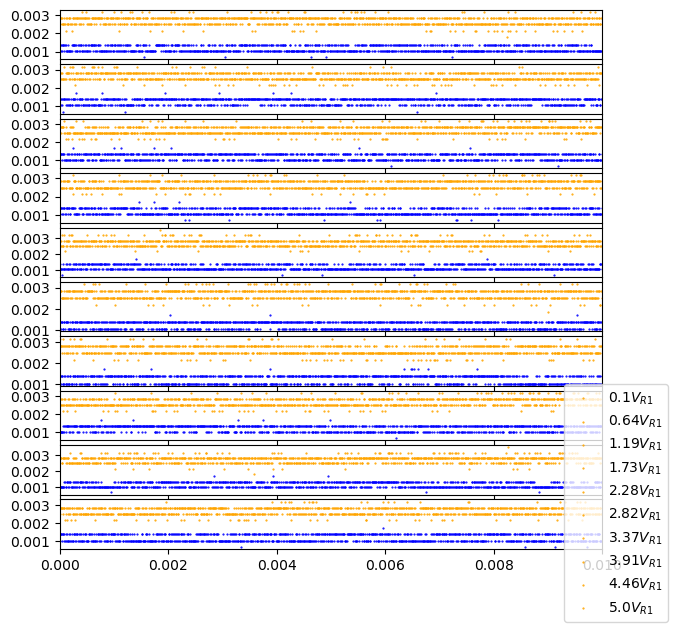

In [41]:
# For quickly checking the measured data. 

with open("series_resistances.pkl","rb") as handle:
    data = pickle.load(handle)

n_volt = data.keys()

fig, axes = plt.subplots(len(n_volt),1,figsize=(7,7),sharex=True)
fig.subplots_adjust(hspace=0.1)

for i,volt in enumerate(n_volt):
    # We only look at the first attempt at each volt. 
    v0 = data[volt][0][0]
    v1 = data[volt][0][1]
    axes[i].scatter(t,v0,color="orange",s=0.3,label=str(volt)+"$V_{R1}$")
    axes[i].scatter(t,v1,color="blue",s=0.3)#,label=str(volt)+"$V_{R2}$")
fig.legend(loc="lower right")
axes[0].set_xlim(0.0,0.01)
